# Data Source and goal of this case study

Data: https://www.kaggle.com/patrickb1912/ipl-complete-dataset-20082020  
          
Goal:   
    1. Identify cluster of players with similar performance  
    2. Given a player name, identify similar players  
    3. Create a best team with mix of batsman, bowler, allrounders & wicket-keeper
    

# Imports and data read

In [625]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [626]:
balldf = pd.read_csv("data/IPL_2008_2020/IPL Ball-by-Ball 2008-2020.csv")

In [627]:
matches = pd.read_csv("data/IPL_2008_2020/IPL Matches 2008-2020.csv")

In [628]:
balldf.head()

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [629]:
balldf.shape

(193468, 18)

In [630]:
matches.head()

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,Mumbai,2008-04-20,MV Boucher,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper
4,335986,Kolkata,2008-04-20,DJ Hussey,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan


# Check Missing

In [631]:
balldf.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

The variables with missing data is not used to create the player statistics in this analysis and can be ignored.

# Create batsman statistics

## Variables by grouping on batsman

In [632]:
batgroup = balldf.groupby(['batsman'])

In [633]:
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)




## Derived variable - Batsman average & strike rate

In [634]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [635]:
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['bat_strike'] = round(batdf['runs']/batdf['balls_faced']*100,2)


In [636]:
display(batdf.tail())

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike
batsman,,,,,,,
YV Takawale,183,10,192,26.0,3.0,19.20,104.92
Yashpal Singh,67,4,47,5.0,0.0,11.75,70.15
Younis Khan,7,1,3,0.0,0.0,3.00,42.86
Yuvraj Singh,2205,126,2750,217.0,149.0,21.83,124.72
Z Khan,141,27,117,11.0,2.0,4.33,82.98


# Create bowler statistics

## Variables by grouping on bowler

In [637]:
bowlgroup = balldf.groupby(['bowler'])

In [638]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [639]:
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['over'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

bowldf.head()


,balls_bowled,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45,396.0
A Chandila,234,11.0,39,242.0
A Choudhary,108,5.0,17,144.0
A Dananjaya,25,0.0,4,47.0
A Flintoff,66,2.0,11,105.0


## Derived variable - Bowler econ rate

In [640]:
# Note - roughly apprx to overs.  Should be runs_conceded/overs.balls
bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [641]:
display(bowldf.tail())

,balls_bowled,wickets,overs,runs_conceded,bowl_econ
bowler,,,,,
YA Abdulla,222,15.0,35,307.0,8.77
YK Pathan,1184,42.0,193,1415.0,7.33
YS Chahal,2188,121.0,359,2723.0,7.58
Yuvraj Singh,882,36.0,146,1077.0,7.38
Z Khan,2276,102.0,371,2782.0,7.50


# Merge to player statistics

In [642]:
players = pd.merge(batdf,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [643]:
players.tail()

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ
YV Takawale,183.0,10.0,192.0,26.0,3.0,19.20,104.92,0.0,0.0,0.0,0.0,0.00
Yashpal Singh,67.0,4.0,47.0,5.0,0.0,11.75,70.15,0.0,0.0,0.0,0.0,0.00
Younis Khan,7.0,1.0,3.0,0.0,0.0,3.00,42.86,0.0,0.0,0.0,0.0,0.00
Yuvraj Singh,2205.0,126.0,2750.0,217.0,149.0,21.83,124.72,882.0,36.0,146.0,1077.0,7.38
Z Khan,141.0,27.0,117.0,11.0,2.0,4.33,82.98,2276.0,102.0,371.0,2782.0,7.50


# Create no. of catches statistics

In [644]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [645]:
# Total catches = Number of caught & bowled + number of catches as fielder
# Capture caught & bowled instances
catches_cb = balldf[(balldf['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
# Capture the catches
catches_c = balldf[(balldf['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')
# Combine the caught & bowled and fielding catches to get the total catches.
catches_df = pd.merge(catches_cb,catches_c, left_index=True, right_index=True,how='outer')
catches_df.fillna(0,inplace=True)
catches_df['catches'] = catches_df['bowler_catches']+catches_df['fielder_catches']
catches_df.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
# Merge total catches to players data
players = pd.merge(players,catches_df, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)
display(players.head())

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches
A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0
A Chandila,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0
A Chopra,75.0,6.0,53.0,7.0,0.0,8.83,70.67,0.0,0.0,0.0,0.0,0.00,2.0
A Choudhary,20.0,3.0,25.0,1.0,1.0,8.33,125.00,108.0,5.0,17.0,144.0,8.47,0.0
A Dananjaya,5.0,1.0,4.0,0.0,0.0,4.00,80.00,25.0,0.0,4.0,47.0,11.75,0.0


In [646]:
players.head()

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches
A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0
A Chandila,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0
A Chopra,75.0,6.0,53.0,7.0,0.0,8.83,70.67,0.0,0.0,0.0,0.0,0.00,2.0
A Choudhary,20.0,3.0,25.0,1.0,1.0,8.33,125.00,108.0,5.0,17.0,144.0,8.47,0.0
A Dananjaya,5.0,1.0,4.0,0.0,0.0,4.00,80.00,25.0,0.0,4.0,47.0,11.75,0.0


# Number of man of the  matches from matches file

In [647]:
players.shape

(648, 13)

In [648]:
players = pd.merge(players,matches['player_of_match'].value_counts(), left_index=True, right_index=True,how='left')
players['player_of_match']  = players[['player_of_match']].fillna(0)

# Filtering: Remove players who have played less matches

In [649]:
# Backup before data filtering
all_players = players.copy()

In [650]:
players.shape

(648, 14)

In [651]:
players['innings'].describe()

count    648.000000
mean      18.768519
std       32.885716
min        0.000000
25%        1.000000
50%        5.000000
75%       19.000000
max      194.000000
Name: innings, dtype: float64

In [652]:
# Cut off on no. of matches

# Current Analysis: Players who have played atleast 10 match(es)
CUTOFF_MATCHES = 10
players=players[players['innings']>=CUTOFF_MATCHES]

In [653]:
players.shape

(251, 14)

# Scale the data

In [654]:
# instantiate
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()


# TESTING -  CONSIDER  ONLY RUNS AND WICKETS
#players_scaled  = players_scaled[['runs','wickets','catches']]


# players_scaled.columns=players.columns

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
0,-0.586132,-0.514618,-0.537008,-0.596562,-0.394531,-0.476250,1.197842,-0.400299,-0.220922,-0.391620,-0.353023,0.772222,-0.561588,-0.755049
1,-0.746431,-0.707912,-0.743238,-0.710905,-0.698918,-1.604319,-2.082638,0.495151,0.507283,0.520538,0.320197,0.193070,-0.513659,0.003020
2,-0.352772,0.234399,-0.467985,-0.482219,-0.597456,-1.103337,-1.308329,3.320906,3.608900,3.349777,3.176804,0.398656,0.013558,2.024537
3,-0.731164,-0.659589,-0.738188,-0.710905,-0.678626,-1.595148,-2.374267,1.739740,2.152489,1.734173,1.781551,0.521507,-0.082300,0.761089
4,0.051791,-0.200514,0.047168,-0.086415,0.133073,1.230758,0.364289,-0.061208,-0.166981,-0.059223,-0.070311,0.486407,0.013558,0.003020


In [655]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
count,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02
mean,5.661695e-17,-3.538559e-18,-4.246271e-17,2.830848e-17,7.607903e-17,7.430975e-17,-1.698509e-16,5.750159e-17,-2.476992e-17,-1.769280e-17,-5.307839e-18,-7.784831e-17,4.157807e-17,5.130911e-17
std,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00
min,-7.551544e-01,-8.287215e-01,-7.592314e-01,-7.372922e-01,-6.989182e-01,-1.775134e+00,-3.729996e+00,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-9.929471e-01,-7.550485e-01
25%,-6.493792e-01,-6.837506e-01,-6.380189e-01,-6.405401e-01,-5.974558e-01,-7.892201e-01,-5.174868e-01,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-6.574456e-01,-6.287037e-01
50%,-4.498239e-01,-4.662942e-01,-4.570419e-01,-4.558316e-01,-3.945310e-01,-1.518151e-01,1.461410e-01,-4.392317e-01,-4.906282e-01,-4.380013e-01,-4.313278e-01,4.462923e-01,-3.219440e-01,-2.496694e-01
75%,2.279009e-01,4.035312e-01,2.723374e-01,1.730569e-01,1.432196e-01,7.045546e-01,6.393841e-01,4.078669e-01,3.724304e-01,4.007210e-01,3.766374e-01,6.368355e-01,2.292371e-01,2.557098e-01
max,4.226096e+00,3.617053e+00,4.175127e+00,4.460933e+00,6.383156e+00,2.441369e+00,2.536119e+00,3.594691e+00,3.878606e+00,3.612602e+00,3.579515e+00,3.580227e+00,4.662650e+00,5.056812e+00


# update player name as column

In [656]:

#players['player'] = players.index
players.insert(0, 'name', players.index)

In [657]:
players.head()

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,A Kumble,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,A Mishra,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0
A Nehra,A Nehra,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0
A Symonds,A Symonds,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0


# Finding optimal no. of clusters

## Elbow method

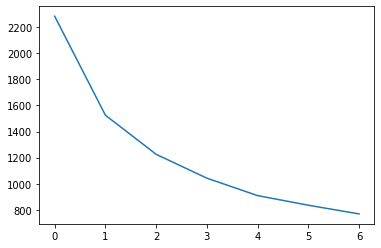

In [658]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(players_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

## Silhouette Analysis¶
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [659]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(players_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(players_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.4244505921125993
For n_clusters=3, the silhouette score is 0.3876906459684048
For n_clusters=4, the silhouette score is 0.33840309847681266
For n_clusters=5, the silhouette score is 0.30625094624718
For n_clusters=6, the silhouette score is 0.30112302235921085
For n_clusters=7, the silhouette score is 0.29574288472247984
For n_clusters=8, the silhouette score is 0.28062350604263486


In [660]:
NUM_CLUSTERS = 8

# k-means Clustering

In [661]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled)

# assign the label
players['cluster_kmeans'] = kmeans.labels_
players.head()

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans
A Ashish Reddy,A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0,7
A Kumble,A Kumble,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0,5
A Mishra,A Mishra,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0,3
A Nehra,A Nehra,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0,5
A Symonds,A Symonds,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0,0


In [662]:
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["innings"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col).head(head_size))

In [663]:
groupby_cluster("cluster_kmeans",5)

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans
0,Yuvraj Singh,2205.0,126.0,2750.0,217.0,149.0,21.83,124.72,882.0,36.0,146.0,1077.0,7.38,31.0,5.0,0
1,V Sehwag,1833.0,104.0,2728.0,334.0,106.0,26.23,148.83,138.0,6.0,23.0,235.0,10.22,34.0,11.0,0
2,JH Kallis,2291.0,95.0,2427.0,255.0,44.0,25.55,105.94,1799.0,65.0,291.0,2293.0,7.88,31.0,10.0,0
3,Mandeep Singh,1364.0,90.0,1659.0,170.0,37.0,18.43,121.63,12.0,0.0,2.0,26.0,13.00,36.0,3.0,0
4,DR Smith,1803.0,88.0,2385.0,245.0,117.0,27.10,132.28,557.0,26.0,90.0,810.0,9.00,41.0,11.0,0
22,KH Pandya,727.0,57.0,1000.0,95.0,40.0,17.54,137.55,1283.0,46.0,210.0,1508.0,7.18,22.0,4.0,1
23,MC Henriques,769.0,50.0,969.0,87.0,27.0,19.38,126.01,918.0,38.0,151.0,1244.0,8.24,27.0,2.0,1
24,R Bhatia,290.0,47.0,342.0,24.0,13.0,7.28,117.93,1661.0,71.0,274.0,2020.0,7.37,25.0,1.0,1
25,Shakib Al Hasan,613.0,46.0,746.0,70.0,20.0,16.22,121.70,1358.0,59.0,224.0,1652.0,7.38,11.0,2.0,1
26,JP Faulkner,405.0,45.0,527.0,36.0,23.0,11.71,130.12,1276.0,59.0,207.0,1778.0,8.59,16.0,5.0,1


# Hierarchical Clustering

## Dendogram

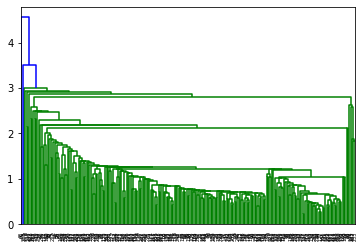

In [664]:
# single linkage
mergings = linkage(players_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

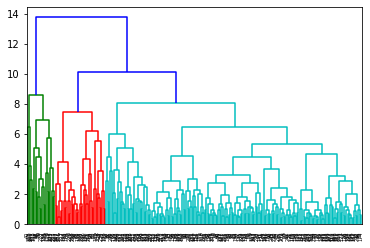

In [665]:
# complete linkage
mergings = linkage(players_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [666]:
# Create the cluster labels
cluster_labels = cut_tree(mergings, n_clusters=NUM_CLUSTERS).reshape(-1, )# assign cluster labels
players['cluster_hier'] = cluster_labels

In [667]:
groupby_cluster("cluster_hier",5)

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans,cluster_hier
0,STR Binny,700.0,66.0,880.0,66.0,35.0,13.33,125.71,611.0,22.0,99.0,758.0,7.66,19.0,0.0,7,0
1,Y Venugopal Rao,865.0,52.0,985.0,77.0,37.0,18.94,113.87,222.0,6.0,36.0,337.0,9.36,13.0,0.0,7,0
2,AM Nayar,588.0,50.0,672.0,55.0,20.0,13.44,114.29,239.0,9.0,39.0,322.0,8.26,13.0,0.0,7,0
3,DJ Hooda,504.0,50.0,625.0,32.0,29.0,12.50,124.01,239.0,7.0,39.0,322.0,8.26,25.0,1.0,7,0
4,MC Henriques,769.0,50.0,969.0,87.0,27.0,19.38,126.01,918.0,38.0,151.0,1244.0,8.24,27.0,2.0,1,0
118,RA Jadeja,1774.0,136.0,2159.0,157.0,76.0,15.88,121.70,2759.0,114.0,457.0,3470.0,7.59,68.0,9.0,3,1
119,DJ Bravo,1199.0,101.0,1490.0,116.0,61.0,14.75,124.27,2846.0,153.0,458.0,3798.0,8.29,75.0,3.0,3,1
120,Harbhajan Singh,632.0,86.0,829.0,79.0,42.0,9.64,131.17,3451.0,150.0,563.0,3967.0,7.05,48.0,8.0,3,1
121,IK Pathan,981.0,82.0,1139.0,87.0,37.0,13.89,116.11,2113.0,80.0,345.0,2649.0,7.68,31.0,2.0,3,1
122,PP Chawla,541.0,75.0,584.0,54.0,18.0,7.79,107.95,3285.0,156.0,546.0,4263.0,7.81,40.0,3.0,3,1


#  DBScan Clustering

In [668]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled)
labels = db.labels_

# assign cluster labels
players['cluster_dbscan'] = labels


In [669]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 251


In [670]:
groupby_cluster("cluster_dbscan",5)

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans,cluster_hier,cluster_dbscan
0,RG Sharma,4088.0,194.0,5230.0,458.0,214.0,26.96,127.94,342.0,15.0,56.0,440.0,7.86,89.0,18.0,6,4,-1
1,SK Raina,4041.0,189.0,5368.0,493.0,194.0,28.40,132.84,930.0,25.0,155.0,1118.0,7.21,102.0,14.0,6,4,-1
2,V Kohli,4609.0,184.0,5878.0,504.0,202.0,31.95,127.53,264.0,4.0,43.0,368.0,8.56,76.0,13.0,6,4,-1
3,RV Uthappa,3658.0,182.0,4607.0,454.0,163.0,25.31,125.94,0.0,0.0,0.0,0.0,0.00,87.0,7.0,6,5,-1
4,MS Dhoni,3493.0,182.0,4632.0,313.0,216.0,25.45,132.61,0.0,0.0,0.0,0.0,0.00,113.0,17.0,6,4,-1


# Comparing clustering results

In [671]:
print(f"K-means clustering with k={NUM_CLUSTERS}")
print(players['cluster_kmeans'].value_counts())
print(f"\nHierarchical clustering with k={NUM_CLUSTERS}")
print(players['cluster_hier'].value_counts())
print(f"\nDBScan clustering")
print(players['cluster_dbscan'].value_counts())

K-means clustering with k=8
7    65
4    50
1    36
5    25
2    25
0    22
3    16
6    12
Name: cluster_kmeans, dtype: int64

Hierarchical clustering with k=8
0    118
3     40
6     34
1     20
2     18
5     10
4      7
7      4
Name: cluster_hier, dtype: int64

DBScan clustering
-1    251
Name: cluster_dbscan, dtype: int64


In [672]:
players.groupby(['cluster_dbscan']).head().sort_values(by='cluster_dbscan')

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans,cluster_hier,cluster_dbscan
A Ashish Reddy,A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0,7,0,-1
A Kumble,A Kumble,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0,5,0,-1
A Mishra,A Mishra,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0,3,1,-1
A Nehra,A Nehra,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0,5,2,-1
A Symonds,A Symonds,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0,0,3,-1


In [673]:
groupby_cluster("cluster_dbscan",5)

,name,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans,cluster_hier,cluster_dbscan
0,RG Sharma,4088.0,194.0,5230.0,458.0,214.0,26.96,127.94,342.0,15.0,56.0,440.0,7.86,89.0,18.0,6,4,-1
1,SK Raina,4041.0,189.0,5368.0,493.0,194.0,28.40,132.84,930.0,25.0,155.0,1118.0,7.21,102.0,14.0,6,4,-1
2,V Kohli,4609.0,184.0,5878.0,504.0,202.0,31.95,127.53,264.0,4.0,43.0,368.0,8.56,76.0,13.0,6,4,-1
3,RV Uthappa,3658.0,182.0,4607.0,454.0,163.0,25.31,125.94,0.0,0.0,0.0,0.0,0.00,87.0,7.0,6,5,-1
4,MS Dhoni,3493.0,182.0,4632.0,313.0,216.0,25.45,132.61,0.0,0.0,0.0,0.0,0.00,113.0,17.0,6,4,-1


# Plots

## Runs vs Wickets

In [674]:
# Plotly scatter plot
import plotly.express as px
fig = px.scatter(players, x="runs",   y="wickets", color="cluster_kmeans",
                 size='catches', hover_data=['name'], title = 'Scatter Plot: Runs vs Wickets, Size = catches', color_discrete_sequence=px.colors.qualitative.Light24)
fig.show()

# color_discrete_sequence - https://plotly.com/python/discrete-color/

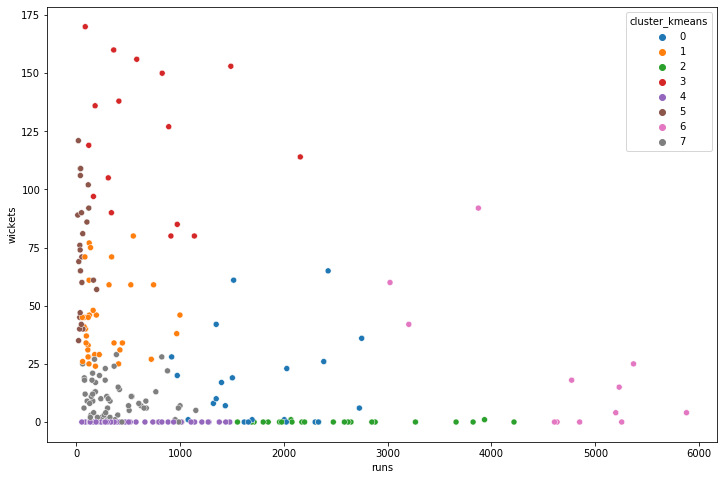

In [675]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_kmeans", data=players, palette="tab10")

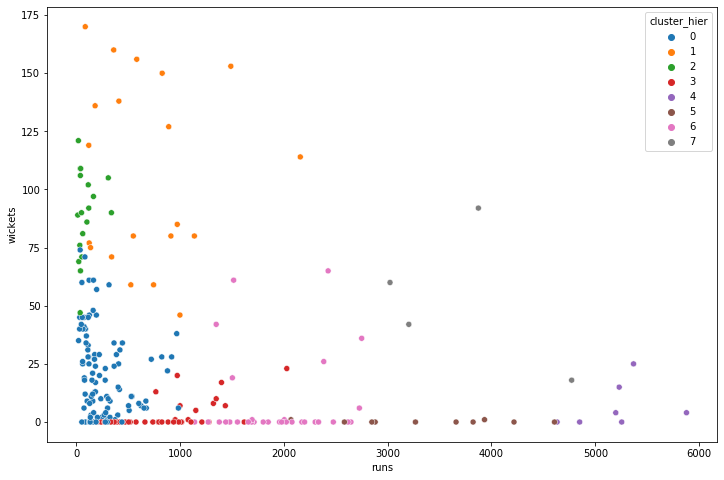

In [676]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_hier", data=players, palette="tab10")

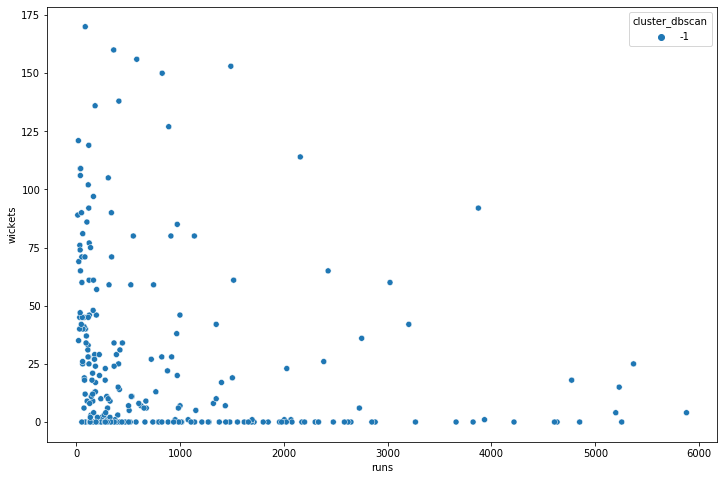

In [677]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_dbscan", data=players, palette="tab10")

## Runs vs catches

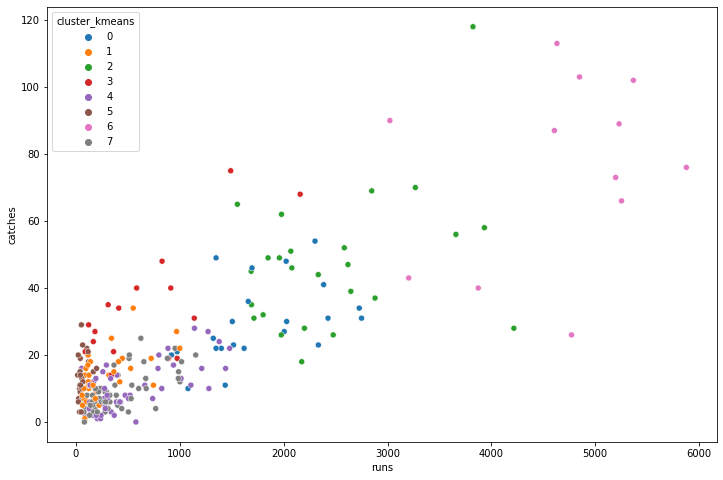

In [678]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="catches", hue="cluster_kmeans", data=players, palette="tab10")

# Only runs & wickets

In [679]:
cols = ['bat_average','bowl_econ']

In [680]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled[cols])

# assign the label
players['cluster_kmeans_small'] = kmeans.labels_


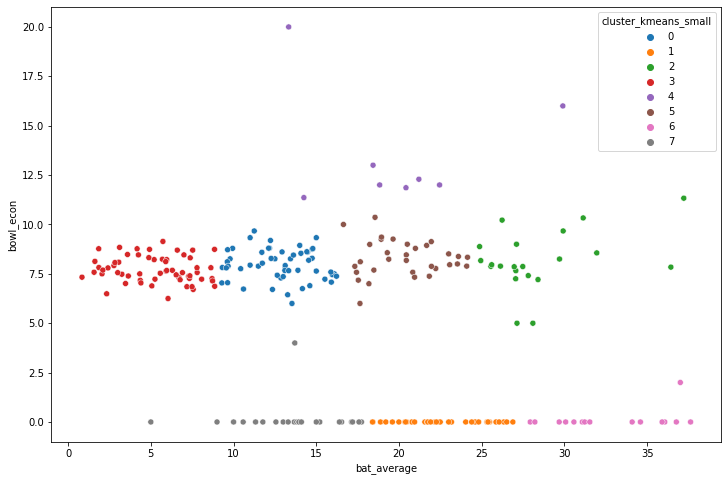

In [681]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_kmeans_small", data=players, palette="tab10")

In [682]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled[cols])
labels = db.labels_

# assign cluster labels
players['cluster_dbscan_avgecon'] = labels

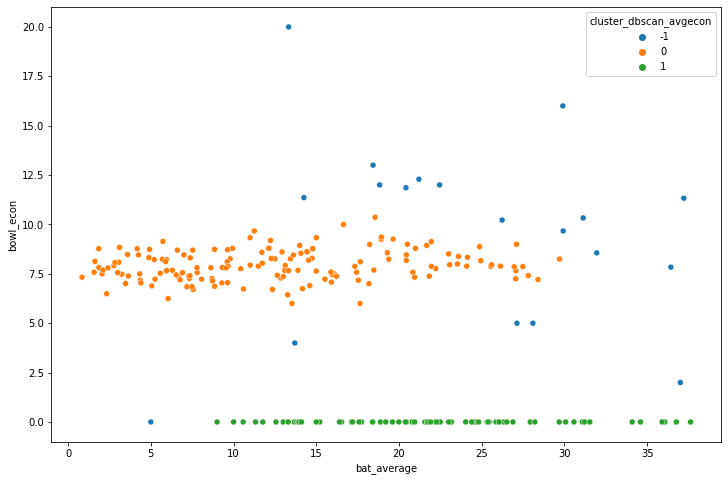

In [683]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_dbscan_avgecon", data=players, palette="tab10")

# References

In [684]:
# https://www.linkedin.com/pulse/ai-daily-life-clustering-cricket-players-ramachandran-s/
    